# Data Science Aplicada à Área de Saúde

Projeto de análise de dados da formação FIAMED da [DSA](https://www.datascienceacademy.com.br/)

## Detecção de cancer de pulmão em imagens médicas com Deep Learning

## Treinamento do modelo

Treinamento de um modelo de Deep Learning com arquitetura de Rede Neural Convolucional.

O dataset contém imagens radiológicas de pulmoẽs com e sem câncer previamente rotulados.

### Carregando pacotes

In [1]:
# Compatibilidade CuDNN
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
# Imports
import os
import sys
import cv2
import random
import tensorflow
import keras
import itertools
import matplotlib as m
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import imutils
import argparse
from imutils import paths

In [3]:
# Configuração dos plots
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,7
%matplotlib inline

In [4]:
# Versões dos pacotes
%reload_ext watermark
%watermark -a "19/08/2020" --iversions

matplotlib 3.2.2
keras      2.4.3
tensorflow 2.3.0
imutils    0.5.3
cv2.cv2    4.4.0
numpy      1.18.5
argparse   1.1
19/08/2020


### Carregando imagens

In [5]:
# Carregar imagens em disco
imagens_treino = "./dados/treino/"

In [6]:
# Lista para armazenar as imagens e labels
imagens = []
labels = []

In [7]:
# Lista as imagems e faz o shuffle
imagePaths = sorted(list(paths.list_images(imagens_treino)))
random.seed(42)
random.shuffle(imagePaths)

In [8]:
# Loop pelas imagens e leitura com OpenCV
for imagePath in imagePaths:
    
    # Leitura de imagem
    image = cv2.imread(imagePath)
    
    # Redimensionamento para 40x40 pixels
    image = cv2.resize(image, (40, 40))
    
    # Converte a imagem para array
    image = img_to_array(image)
    
    # Adiciona à lista de imagens
    imagens.append(image)
    
    # Extrai o label
    label = imagePath[-7:-4]
    
    # define o valor 0 ou 1 para o label
    if label == "pos":
        label = 1
    else:
         label = 0
    
    # Adiciona à lista de labels
    labels.append(label)

In [9]:
# Normalização das imagens
imagens = np.array(imagens, dtype='float')/255.0

In [10]:
# Visualização das imagens
imagens

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.07058824, 0.07058824, 0.07058824],
         [0.09411765, 0.09411765, 0.09411765],
         ...,
         [0.09803922, 0.09803922, 0.09803922],
         [0.01960784, 0.01960784, 0.01960784],
         [0.00784314, 0.00784314, 0.00784314]],

        [[0.03921569, 0.03921569, 0.03921569],
         [0.02352941, 0.02352941, 0.02352941],
         [0.05490196, 0.05490196, 0.05490196],
         ...,
         [0.06666667, 0.06666667, 0.06666667],
         [0.05882353, 0.05882353, 0.05882353],
         [0.03529412, 0.03529412, 0.03529412]],

        [[0.09803922, 0.09803922, 0.09803922],
         [0.06666667, 0.06666667, 0.06666667],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.03137255, 0.03137255, 0.03137255],
         [0.03921569, 0.03921569, 0.03921569],
         [0.06666667, 0.06666667, 0.06666667]],

        ...,

        [[0.19215686, 0.19215686, 0.19215686],
         [0.1372549 , 0.1372549 , 0.1372549 ]

In [11]:
# Carrega os labels
labels = np.array(labels)

In [12]:
# Visualiza os labels
labels

array([0, 0, 1, ..., 0, 0, 1])

Visualizar algumas imagens

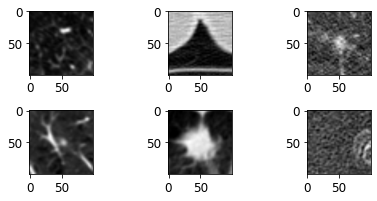

In [13]:
# Plot de imagens
for i, images in enumerate(imagePaths[:6]):
    img = cv2.imread(images)
    img = cv2.resize(img, (100, 100))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.grid(False)
plt.tight_layout()

### Pré-processamento das imagens

Dividir o dataset em treino e teste.

In [14]:
# Divisão em treino e teste com proporção de 75/25
(X_treino, X_teste, y_treino, y_teste) = train_test_split(imagens, labels, test_size = 0.25, random_state = 42)

In [15]:
# Shape (#imagens x altura, largura, #canais de cores)
X_treino.shape

(2206, 40, 40, 3)

In [16]:
# Shape (#imagens x altura, largura, #canais de cores)
X_teste.shape

(736, 40, 40, 3)

Aplicar One-hot encoding na variável target 

In [17]:
# One-Hot Encoding
y_treino = to_categorical(y_treino, num_classes=len(labels))
y_teste = to_categorical(y_teste, num_classes=len(labels))

Criar um gerador de imagens

In [18]:
# Gerador de imagens
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode='nearest')

### Construção do modelo

Hiperparâmetros

In [19]:
# Número de épocas
epochs = 60

# Taxa de aprendizagem
lr = 1e-3

# Tamanho do batch
batch_size = 32

Modelo

In [20]:
# CNN
class ModeloCNN:
    
    @staticmethod
    def build(width, height, depth, classes):
        
        # Cria a sequência de camadas
        model = Sequential()
        
        # Shape de entrada
        inputShape = (height, width, depth)
        
        # Formato das imagens
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        
        # Primeira camada convolucional com ReLU e MaxPooling
        model.add(Conv2D(20, (5, 5), padding='same', input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # Segunda camada concolucional com ReLU e MaxPooling
        model.add(Conv2D(50, (5, 5), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # Primeira camada totalmente conectada com ativação ReLU
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # Camada de saída com classificação softmax
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [21]:
# Cria o modelo
modelo_cnn = ModeloCNN.build(width=40, height=40, depth=3, classes=len(labels))

In [22]:
# Cria o otimizador com algoritmo Adam
otimizador = Adam(lr=lr, decay=lr/epochs)

In [23]:
# Compila o modelo com o otimizador, função de custo e métricas
modelo_cnn.compile(optimizer=otimizador, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Sumarização do modelo
modelo_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 20)        1520      
_________________________________________________________________
activation (Activation)      (None, 40, 40, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0

## Treinamento

In [25]:
%%time

# Treina o modelo
print('\nIniciando o treinamento...\n')

hist = modelo_cnn.fit(aug.flow(X_treino, y_treino, batch_size=batch_size), 
                                validation_data=(X_teste, y_teste), 
                                steps_per_epoch=len(X_treino)//batch_size, 
                                epochs=epochs, 
                                verbose=1)

print('\nTreinamento concluído.\n')


Iniciando o treinamento...

Epoch 1/60
68/68 [==============================] - 1s 16ms/step - loss: 0.9138 - accuracy: 0.7180 - val_loss: 0.4462 - val_accuracy: 0.8043
Epoch 2/60
68/68 [==============================] - 1s 14ms/step - loss: 0.4454 - accuracy: 0.8183 - val_loss: 0.3996 - val_accuracy: 0.8261
Epoch 3/60
68/68 [==============================] - 1s 14ms/step - loss: 0.3988 - accuracy: 0.8349 - val_loss: 0.3395 - val_accuracy: 0.8628
Epoch 4/60
68/68 [==============================] - 1s 14ms/step - loss: 0.3501 - accuracy: 0.8657 - val_loss: 0.3638 - val_accuracy: 0.8546
Epoch 5/60
68/68 [==============================] - 1s 14ms/step - loss: 0.3361 - accuracy: 0.8730 - val_loss: 0.2738 - val_accuracy: 0.8967
Epoch 6/60
68/68 [==============================] - 1s 14ms/step - loss: 0.3143 - accuracy: 0.8822 - val_loss: 0.2460 - val_accuracy: 0.9062
Epoch 7/60
68/68 [==============================] - 1s 14ms/step - loss: 0.3005 - accuracy: 0.8868 - val_loss: 0.2356 - val_a

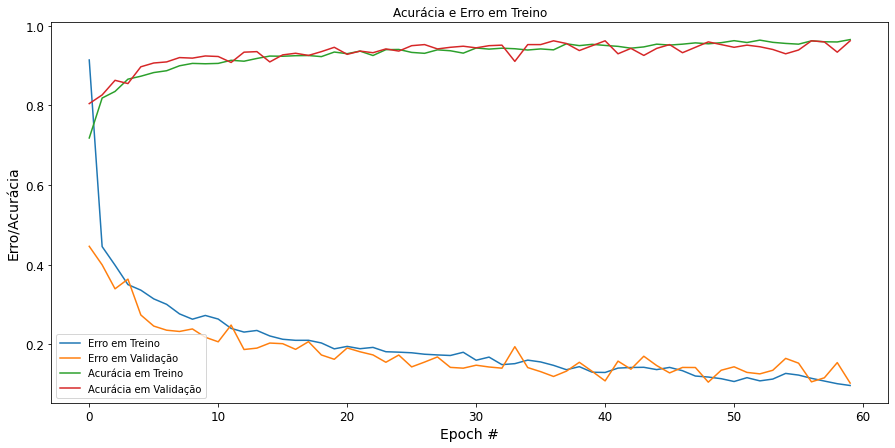

In [26]:
# Plot
plt.figure(figsize = (15,7))
N = epochs
plt.plot(np.arange(0, N), hist.history["loss"], label = "Erro em Treino")
plt.plot(np.arange(0, N), hist.history["val_loss"], label = "Erro em Validação")
plt.plot(np.arange(0, N), hist.history["accuracy"], label = "Acurácia em Treino")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label = "Acurácia em Validação")
plt.title("Acurácia e Erro em Treino")
plt.xlabel("Epoch #")
plt.ylabel("Erro/Acurácia")
plt.legend(loc = "lower left")
plt.show()

Avaliar a acurácia com dados de teste

In [27]:
# Cálculo com dados de teste
score = modelo_cnn.evaluate(X_teste, y_teste, verbose=1)

23/23 [==============================] - 0s 2ms/step - loss: 0.1029 - accuracy: 0.9620


In [28]:
print(f'Acurácia do Modelo em Teste: {score[1]:.2f}')

Acurácia do Modelo em Teste: 0.96


### Matrix de confusão

In [29]:
# Função para criar a MatriX de Confusão
def plot_confusion_matrix(cm, classes = [0,1], normalize = False, title = 'Matriz de Confusão', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')

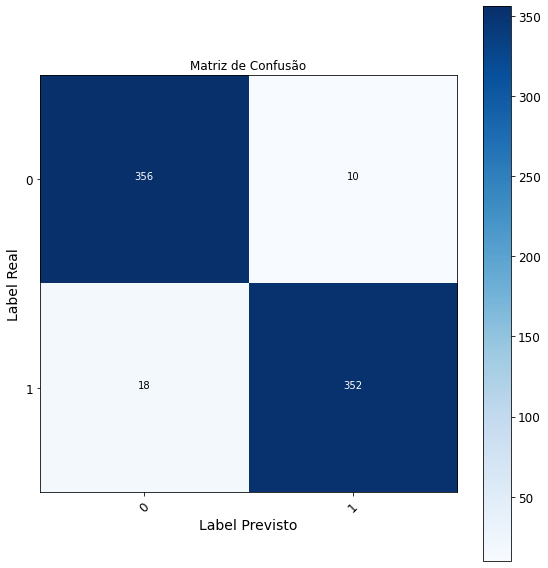

In [30]:
# Aqui ajustamos as previsões com o modelo e então criamos o plot

# Figura
plt.figure(figsize = (8,8))

# Converte os valores previstos com one-hot encoding
# Depreciate
# predY = to_categorical(modelo_cnn.predict_classes(X_teste), num_classes = len(labels))
# Update
predY = to_categorical(np.argmax(modelo_cnn.predict(X_teste), axis=-1), num_classes=len(labels))


# Obtemos valores reais e previstos
try:
    y_teste = [test[0] for test in y_teste]
    predY = [pred[0] for pred in predY]
except TypeError:
    pass

# Cria a matriz de confusão e imprime o plot
cm = confusion_matrix(y_teste, predY)
plot_confusion_matrix(cm)
plt.tight_layout()

### Relatório de Classificação

In [31]:
print(classification_report(predY, y_teste))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       374
         1.0       0.95      0.97      0.96       362

    accuracy                           0.96       736
   macro avg       0.96      0.96      0.96       736
weighted avg       0.96      0.96      0.96       736



Salvar o modelo em disco e usar modelo salvo

In [32]:
# Salvar o modelo
#modelName = 'modelo_cnn.model'
#modelo_cnn.save(modelName)

# Imports
#import cv2
#import imutils
#import argparse
#import numpy as np
#import keras

#from keras.preprocessing.image import img_to_array
#from keras.models import load_model
#import matplotlib.pyplot as plt

# Define o local do modelo
#model = './modelo_cnn.model'

# Carrega o modelo
#model = load_model(model)

## Teste do modelo

### Imagem 1 (cancer)

In [33]:
# Define a imagem a ser testada no diretório com as imagens
image = './dados/teste/imagem1_cancer.png'

Carregar a e visualizar a imagem de teste

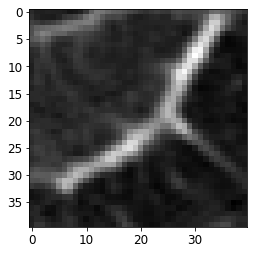

In [34]:
# Carrega a imagem
image = cv2.imread(image)
orig = image.copy()
plt.imshow(image)
plt.show()

Etapa de pré-processamento da imagem de teste

In [35]:
# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype('float') / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

### Previsão

Definir a classe da previsão

In [36]:
# Previsão
(score := modelo_cnn.predict(image)[0])

array([9.9480647e-01, 5.1935869e-03, 1.6931333e-11, ..., 2.0466294e-11,
       2.0245996e-11, 2.2310476e-11], dtype=float32)

In [37]:
# Extrair a classe da previsão
(label := np.argmax(modelo_cnn.predict(image), axis=-1)[0])

0

In [38]:
# Previsão
score = modelo_cnn.predict(image)[0]

# Extrair a classe da previsão
label = np.argmax(modelo_cnn.predict(image), axis=-1)[0]

# Definir a classificação de acordo com o label
if label == 0:
    label = 'No cancer'
else:
    label = 'Cancer'

Calcular o nível de confianca da previsão

In [39]:
# Extrai a maior probabilidade das previsões do modelo
(proba := max(score))

0.99480647

In [40]:
# Extrai a maior probabilidade das previsões do modelo
proba = max(score)

# Print
print(f'Nível de confiança: {proba*100:.2f}%')

# Output
output = imutils.resize(orig, width=400)

# # Verifica a probabilidade
if proba*100 > 95:
    out = f'{label}: {proba*100:.2f}%'
    color = (0,255,0)
else:
    out = 'Not detect'
    color = (255,0,0)
    
# Texto
text = cv2.putText(output, out, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

Nível de confiança: 99.48%


Plotar imagem com o label previsto pelo modelo

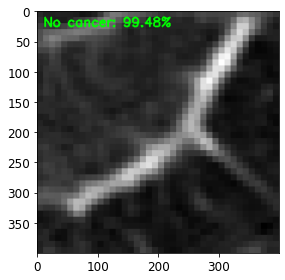

In [41]:
plt.imshow(output)
plt.tight_layout()

### Imagem 2 (cancer)

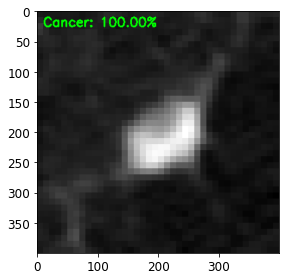

In [42]:
# Define a imagem a ser testada no diretório com as imagens
image = './dados/teste/imagem2_cancer.png'

# Carrega a imagem
image = cv2.imread(image)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype('float') / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Previsão
score = modelo_cnn.predict(image)[0]

# Extrair a classe da previsão
label = np.argmax(modelo_cnn.predict(image), axis=-1)[0]

# Definir a classificação de acordo com o label
if label == 0:
    label = 'No cancer'
else:
    label = 'Cancer'
    
# Extrai a maior probabilidade das previsões do modelo
proba = max(score)

# Output
output = imutils.resize(orig, width=400)

# # Verifica a probabilidade
if proba*100 > 95:
    out = f'{label}: {proba*100:.2f}%'
    color = (0,255,0)
else:
    out = 'Not detect'
    color = (255,0,0)
    
# Texto
text = cv2.putText(output, out, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.imshow(output)
plt.tight_layout()

### Imagem 3 (no cancer)

Nível de confiança: 99.95%


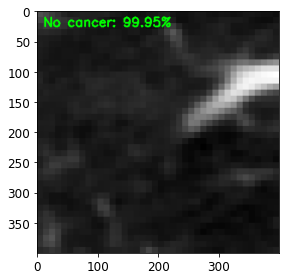

In [43]:
# Define a imagem a ser testada no diretório com as imagens
image = './dados/teste/imagem3_no_cancer.png'

# Carrega a imagem
image = cv2.imread(image)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype('float') / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Previsão
score = modelo_cnn.predict(image)[0]

# Extrair a classe da previsão
label = np.argmax(modelo_cnn.predict(image), axis=-1)[0]

# Definir a classificação de acordo com o label
if label == 0:
    label = 'No cancer'
else:
    label = 'Cancer'

    
# Extrai a maior probabilidade das previsões do modelo
proba = max(score)

# Print
print(f'Nível de confiança: {proba*100:.2f}%')

# Output
output = imutils.resize(orig, width=400)

# # Verifica a probabilidade
if proba*100 > 95:
    out = f'{label}: {proba*100:.2f}%'
    color = (0,255,0)
else:
    out = 'Not detect'
    color = (255,0,0)
    
# Texto
text = cv2.putText(output, out, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.imshow(output)
plt.tight_layout()

### Imagem 4 (no cancer)

Nível de confiança: 97.01%


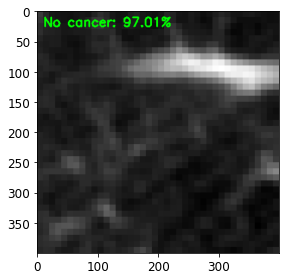

In [44]:
# Define a imagem a ser testada no diretório com as imagens
image = './dados/teste/imagem4_no_cancer.png'

# Carrega a imagem
image = cv2.imread(image)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype('float') / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Previsão
score = modelo_cnn.predict(image)[0]

# Extrair a classe da previsão
label = np.argmax(modelo_cnn.predict(image), axis=-1)[0]

# Definir a classificação de acordo com o label
if label == 0:
    label = 'No cancer'
else:
    label = 'Cancer'
    
# Extrai a maior probabilidade das previsões do modelo
proba = max(score)

# Print
print(f'Nível de confiança: {proba*100:.2f}%')

# Output
output = imutils.resize(orig, width=400)

# # Verifica a probabilidade
if proba*100 > 95:
    out = f'{label}: {proba*100:.2f}%'
    color = (0,255,0)
else:
    out = 'Not detect'
    color = (255,0,0)
    
# Texto
text = cv2.putText(output, out, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.imshow(output)
plt.tight_layout()

# Fim